# Определение стоимости автомобилей

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
 
**Целевой признак**

Price — цена (евро)

**Цель исследования**

Обучить несколько моделей машинного обучения и ,опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

**Ход исследования**

Для задачи данные будут получены из `/datasets/autos.csv`

Я загружу данные, проверю их на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее, создам необходимые столбцы, и приступлю к проведению исследовательского и статического анализа. Основным этапом послужит разработка ML-моделей, оценка результатов обучения. Заключительным этапом послужит расчет выбор лучшей модели и подведение итогов.

**Содержание**
 - [Подготовка данных](#section1)
 - [Обучение моделей](#section2)
 - [Анализ моделей](#section3)
 - [Общий вывод](#section4)

<a id="section1"></a>
## Подготовка данных

### Установка модулей и импорт библиотек

In [1]:
!pip install lightgbm -q

In [2]:
!pip install catboost -q

In [3]:
!pip install phik -q

In [4]:
!pip install scikit-learn==1.5.2 -q

In [5]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
import math
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    RandomizedSearchCV, 
    cross_val_score
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

from phik import phik_matrix 
from phik.report import plot_correlation_matrix


#отключение ограничений вывода графиков по высоте
from IPython.display import display, HTML
display(HTML("<style>.output_wrapper, .output {height:auto !important;}</style>"))

**Инициализация констант**

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка датасета

In [7]:
try:
    predata = pd.read_csv('/datasets/autos.csv')
except Exception as e:
    print(f'Ошибка при загрузке датасета: {e}')
else:
    print('Датасет успешно загружен.')
finally:
    print('Завершена попытка загрузки файлов.')

Датасет успешно загружен.
Завершена попытка загрузки файлов.


### Обзор датасета

In [8]:
predata.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [9]:
predata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
predata.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Выводы**

Отберем значимые признаки:

 - `VehicleType` Тип автомобиля определяет его возможности; чем больше, тем дороже

 - `RegistrationYear` Год регистрации авто показывает "новизну"; новые авто дороже

 - `Gearbox` Тип коробки повышает стоимость

 - `Power` Мощность двигателя напрямую влияет на цену

 - `Model` Модель показывает возможности авто, следовательно влияет на цену

 - `Kilometer` Пробег обратно влияет на цену; чем больше пробег, тем ниже ресурсов авто, следовательно ниже цена

 - `FuelType` Тип топлива определяет ресурсность авто и также влияет на цену

 - `Brand` Бренды, зарекомендовавшиеся себя, как надежные и качественные, оказывают влияение на цену

 - `Repaired` Наличие ремонта авто говорит об утрате некоторых возможностей, что снижает стоимость
 
Проблемы с данными:

 - `Price` равный нулю
 - `RegistrationYear` в районах 1000 и 9999 годов
 - `Power` отсутствие мощности двигателя и наличие ракетных двигателей на авто (20000 л.с.)

**Создание нового датафрейма**

In [11]:
data = predata[['VehicleType', 'RegistrationYear','Gearbox', 
                'Power','Model','Kilometer','FuelType',
                'Brand','Repaired','Price']]

### Обработка дубликатов

**Явные дубликаты**

In [12]:
data.duplicated().sum()

45040

In [13]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

**Неявные дубликаты**

In [14]:
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

for col in categorical_cols:
    print(data[col].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3

***FuelType***

Gasoline и Petrol - понятия, обозначающие одно и тоже понятие (бензин), поэтому объединяем

In [15]:
data['FuelType'] = data['FuelType'].replace({'gasoline': 'petrol'})

lpg и cng - обозначения газа, поэтому также можем объединить в одну категорию

In [16]:
data['FuelType'] = data['FuelType'].replace({'lpg': 'gas', 'cng': 'gas'})

### Обработка Price

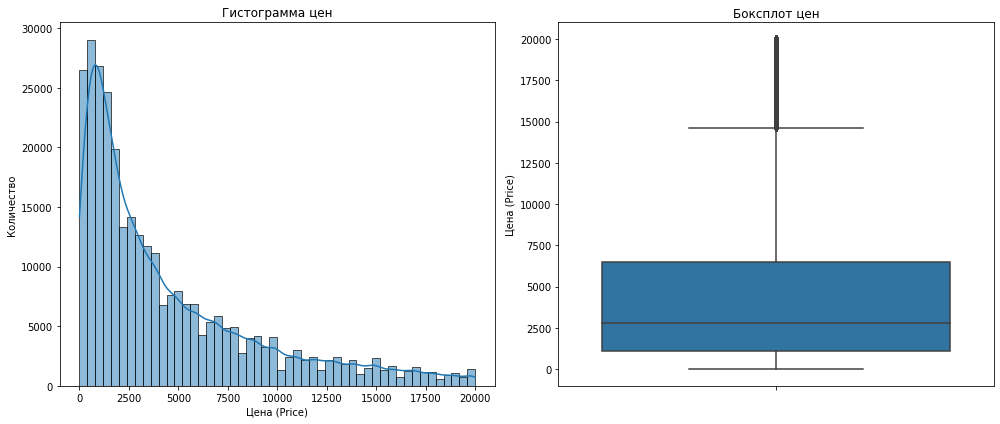

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data['Price'], bins=50, kde=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Гистограмма цен')
axes[0].set_xlabel('Цена (Price)')
axes[0].set_ylabel('Количество')

sns.boxplot(y=data['Price'], ax=axes[1])
axes[1].set_title('Боксплот цен')
axes[1].set_ylabel('Цена (Price)')

plt.tight_layout()
plt.show()

In [18]:
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Границы для усечения:\nНижняя: {lower_bound}\nВерхняя: {upper_bound}")

Границы для усечения:
Нижняя: -7000.0
Верхняя: 14600.0


Предел: 500 ≤ Price ≤ 15,000.
Нижняя граница (500): Убирает нереалистичные цены.
Верхняя граница (15,000): Соответствует усу боксплота и предоставленной границе (14,600), но чуть мягче.

In [19]:
data = data.query('500 <= Price <= 14600')

data['Price'].describe()

count    261153.000000
mean       4234.930271
std        3523.153973
min         500.000000
25%        1450.000000
50%        2999.000000
75%        6200.000000
max       14600.000000
Name: Price, dtype: float64

### Обработка RegistrationYear

Проверим в каком году отбираются анкета, а также минимум года регистрации

In [20]:
print(pd.to_datetime(predata['RegistrationYear'].min()))
print(pd.to_datetime(predata['DateCrawled'].max()))

1970-01-01 00:00:00.000001
2016-04-07 14:36:58


In [21]:
data = data.query('1970 <= RegistrationYear <= 2016')

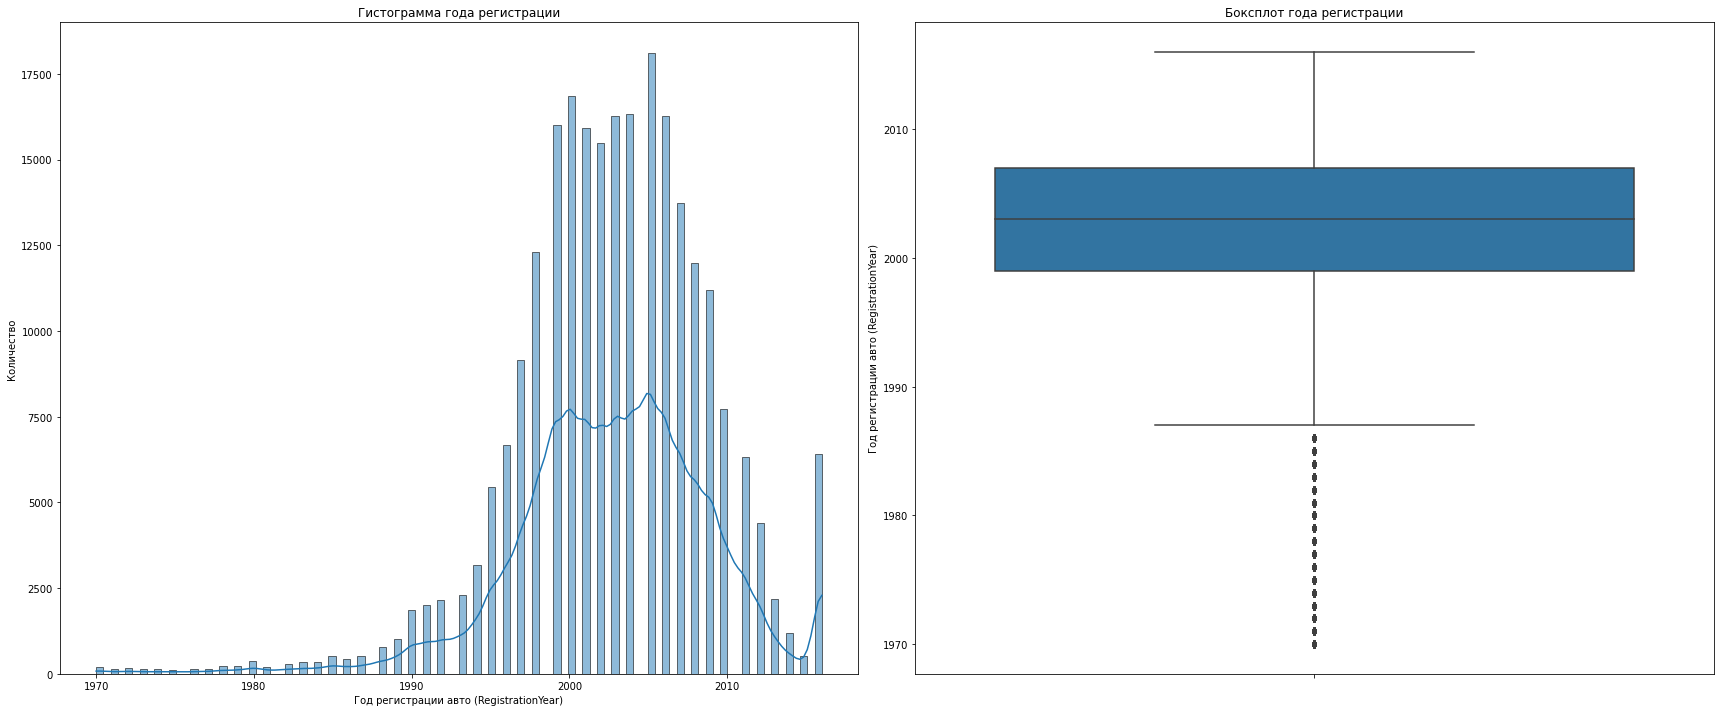

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

sns.histplot(data['RegistrationYear'], bins=100, kde=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Гистограмма года регистрации')
axes[0].set_xlabel('Год регистрации авто (RegistrationYear)')
axes[0].set_ylabel('Количество')

sns.boxplot(y=data['RegistrationYear'], ax=axes[1])
axes[1].set_title('Боксплот года регистрации')
axes[1].set_ylabel('Год регистрации авто (RegistrationYear)')

plt.tight_layout()
plt.show()

### Обработка Power

In [23]:
data['Power'].describe()

count    248387.000000
mean        113.186540
std         198.035602
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Оставим более реальные значения в пределах 0 < Power < 1000

In [24]:
data = data.query('0 < Power < 1000')

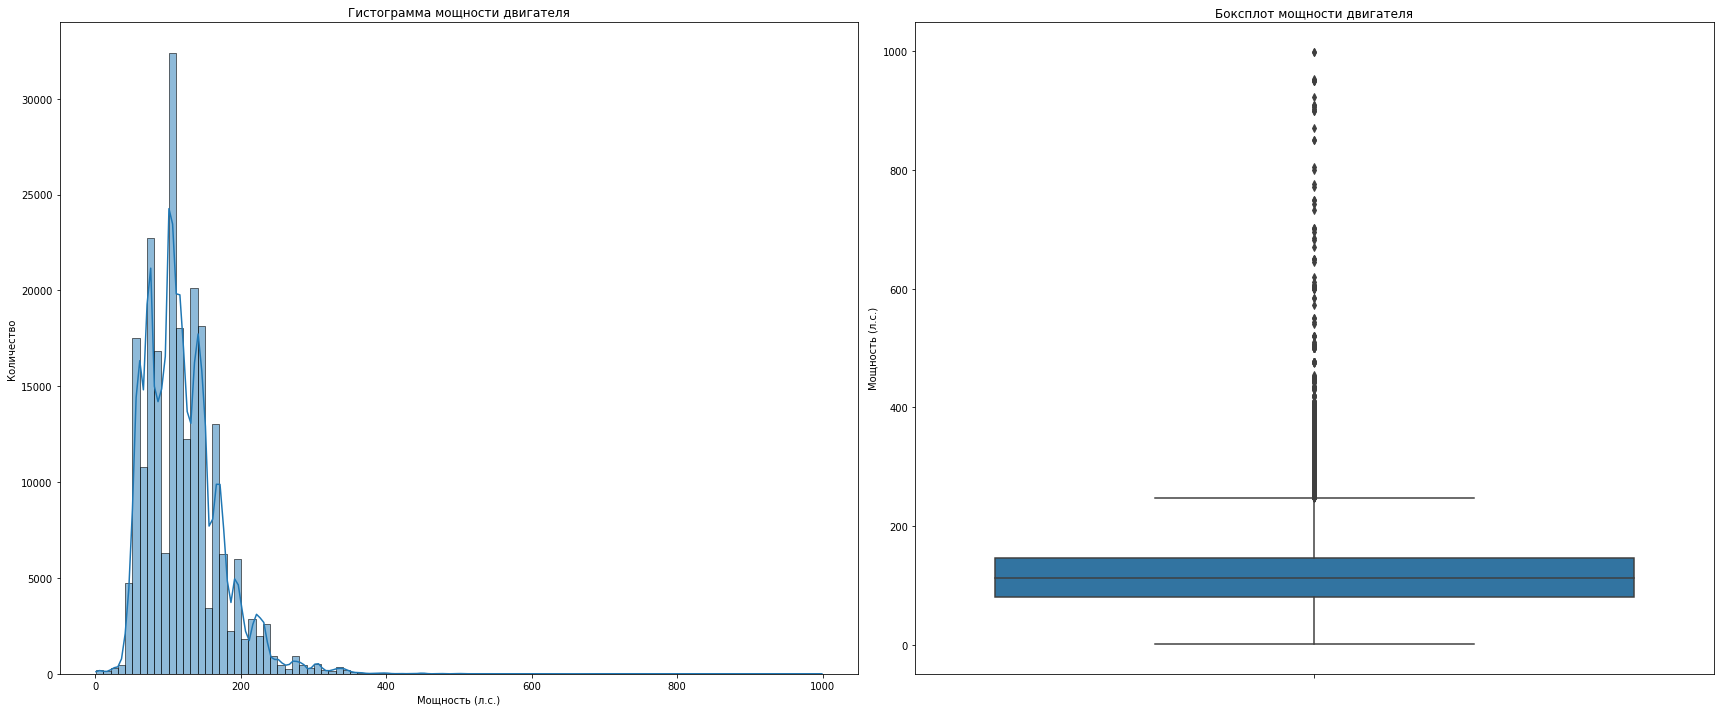

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

sns.histplot(data['Power'], bins=100, kde=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Гистограмма мощности двигателя')
axes[0].set_xlabel('Мощность (л.с.)')
axes[0].set_ylabel('Количество')

sns.boxplot(y=data['Power'], ax=axes[1])
axes[1].set_title('Боксплот мощности двигателя')
axes[1].set_ylabel('Мощность (л.с.)')

plt.tight_layout()
plt.show()

Как видно из графика, верхнюю границу можно оставить в пределе 400 л.с

In [26]:
data = data.query('Power <= 400')

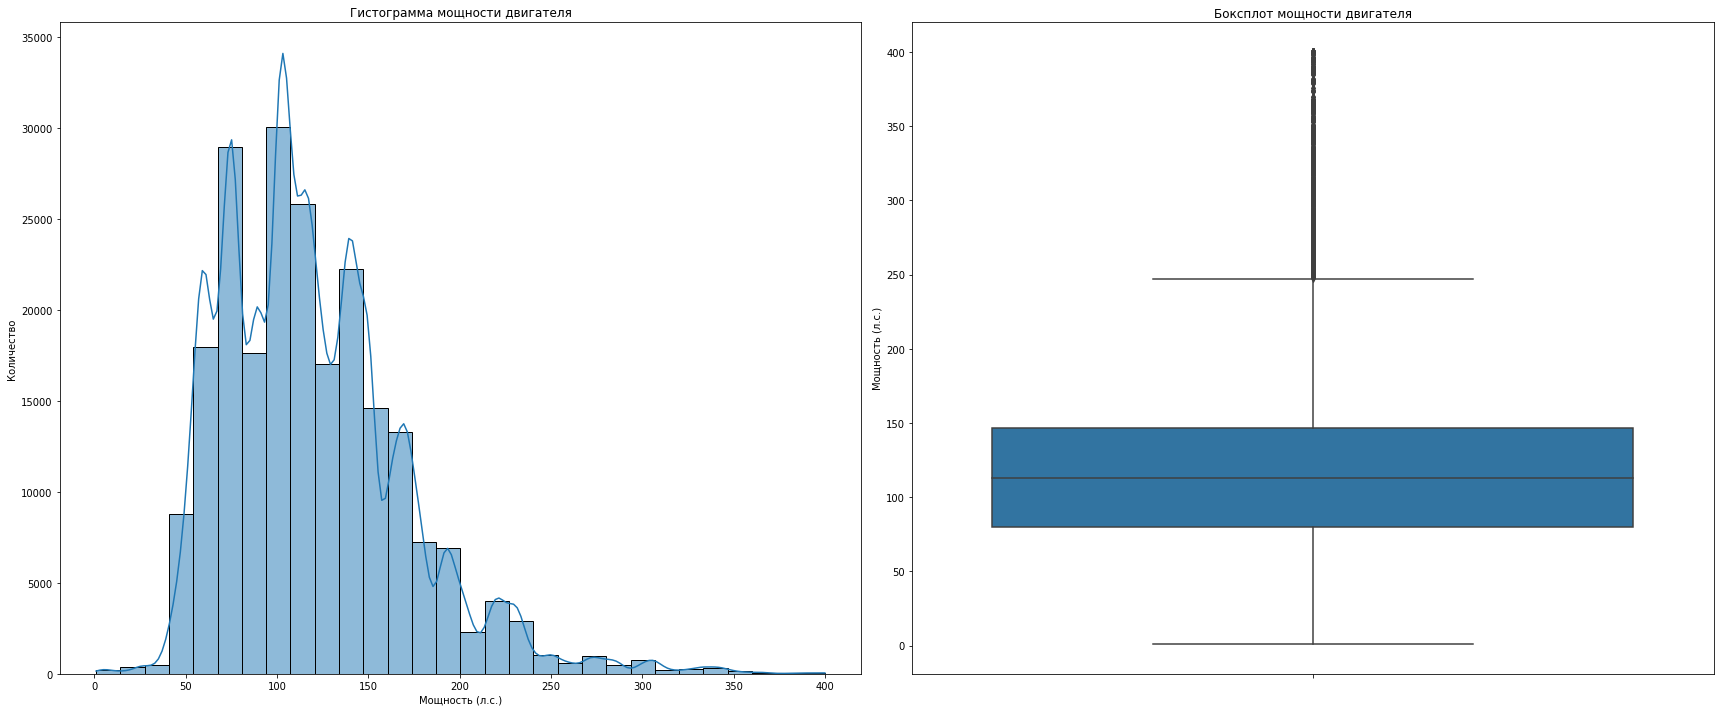

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

sns.histplot(data['Power'], bins=30, kde=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Гистограмма мощности двигателя')
axes[0].set_xlabel('Мощность (л.с.)')
axes[0].set_ylabel('Количество')

sns.boxplot(y=data['Power'], ax=axes[1])
axes[1].set_title('Боксплот мощности двигателя')
axes[1].set_ylabel('Мощность (л.с.)')

plt.tight_layout()
plt.show()

Приступим к обработке пропущенных значений

### Обработка пропущенных значений

In [28]:
data.isna().sum()

VehicleType          7924
RegistrationYear        0
Gearbox              4225
Power                   0
Model                8782
Kilometer               0
FuelType            12023
Brand                   0
Repaired            33030
Price                   0
dtype: int64

**VehicleType**

Замена пропусков в Vehicle по моде для каждого Brand будет целесообразной, так как сохраняет 7924 строки, минимизирует потерю данных после очистки, логично отражает типичную модель бренда

In [29]:
data['VehicleType'] = data.groupby('Brand')['VehicleType'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else data['VehicleType'].mode()[0])
)

**Gearbox**

Замена пропусков аналогично модой окажет минимальное влияние на распределение, так как пропусков мало (1.87%)

In [30]:
mode_gearbox = data['Gearbox'].mode()[0]
data['Gearbox'] = data['Gearbox'].fillna(mode_gearbox)
print("Распределение Gearbox после заполнения:\n", data['Gearbox'].value_counts())

Распределение Gearbox после заполнения:
 manual    181495
auto       44334
Name: Gearbox, dtype: int64


**Model**

Часто производители автомобилей дают уникальные названия своим автомобилям (Rio есть только у Kia), поэтому стоит проверить их корреляцию между собой, тогда логичным будет объединить строки `Brand` и `Model`

In [31]:
data['Model'] = data.groupby('Brand')['Model'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown'))


data_encoded = data.copy()

le_brand = LabelEncoder()
le_model = LabelEncoder()
data_encoded['Brand'] = le_brand.fit_transform(data_encoded['Brand'])
data_encoded['Model'] = le_model.fit_transform(data_encoded['Model'].astype(str)) 

corr_matrix = data_encoded[['Brand', 'Model']].corr()
print("Корреляция между Brand и Model:\n", corr_matrix)

Корреляция между Brand и Model:
          Brand    Model
Brand  1.00000  0.46743
Model  0.46743  1.00000


Несмотря на умеренную коррреляцию (могло быть и выше (но здесь играет роль кодировщика), объединим данные признаки

In [32]:
data['Brand_Model'] = data['Brand'] + '_' + data['Model']
data.drop(['Brand', 'Model'], axis=1, inplace=True)
print("Уникальных Brand_Model:", data['Brand_Model'].nunique())

Уникальных Brand_Model: 297


**FuelType**

In [33]:
data['FuelType'].value_counts()

petrol      208998
gas           4531
hybrid         144
other           69
electric        64
Name: FuelType, dtype: int64

Аналогично заполним пропуски по моде бренда авто

In [34]:
data['FuelType'] = data.groupby('Brand_Model')['FuelType'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'unknown')
)

**Repaired**

Налчиие пропусков в данном признаке скорее может интерпретироваться как отсутствие ремонта авто, следовательно заполним пропуски значением `no`, а также приведем данный признак к бинарному

In [35]:
data['Repaired'] = data['Repaired'].fillna('no')

data['Repaired'] = data['Repaired'].map({'yes': 1, 'no': 0})

print("Распределение Repaired:\n", data['Repaired'].value_counts())

Распределение Repaired:
 0    204817
1     21012
Name: Repaired, dtype: int64


In [36]:
data.isna().sum()

VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Kilometer           0
FuelType            0
Repaired            0
Price               0
Brand_Model         0
dtype: int64

### Корреляционный анализ

In [37]:
def matrix(data, inter_cols):

    phik_overview = phik_matrix(data, interval_cols=inter_cols) 

    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(20, 15)
    ) 

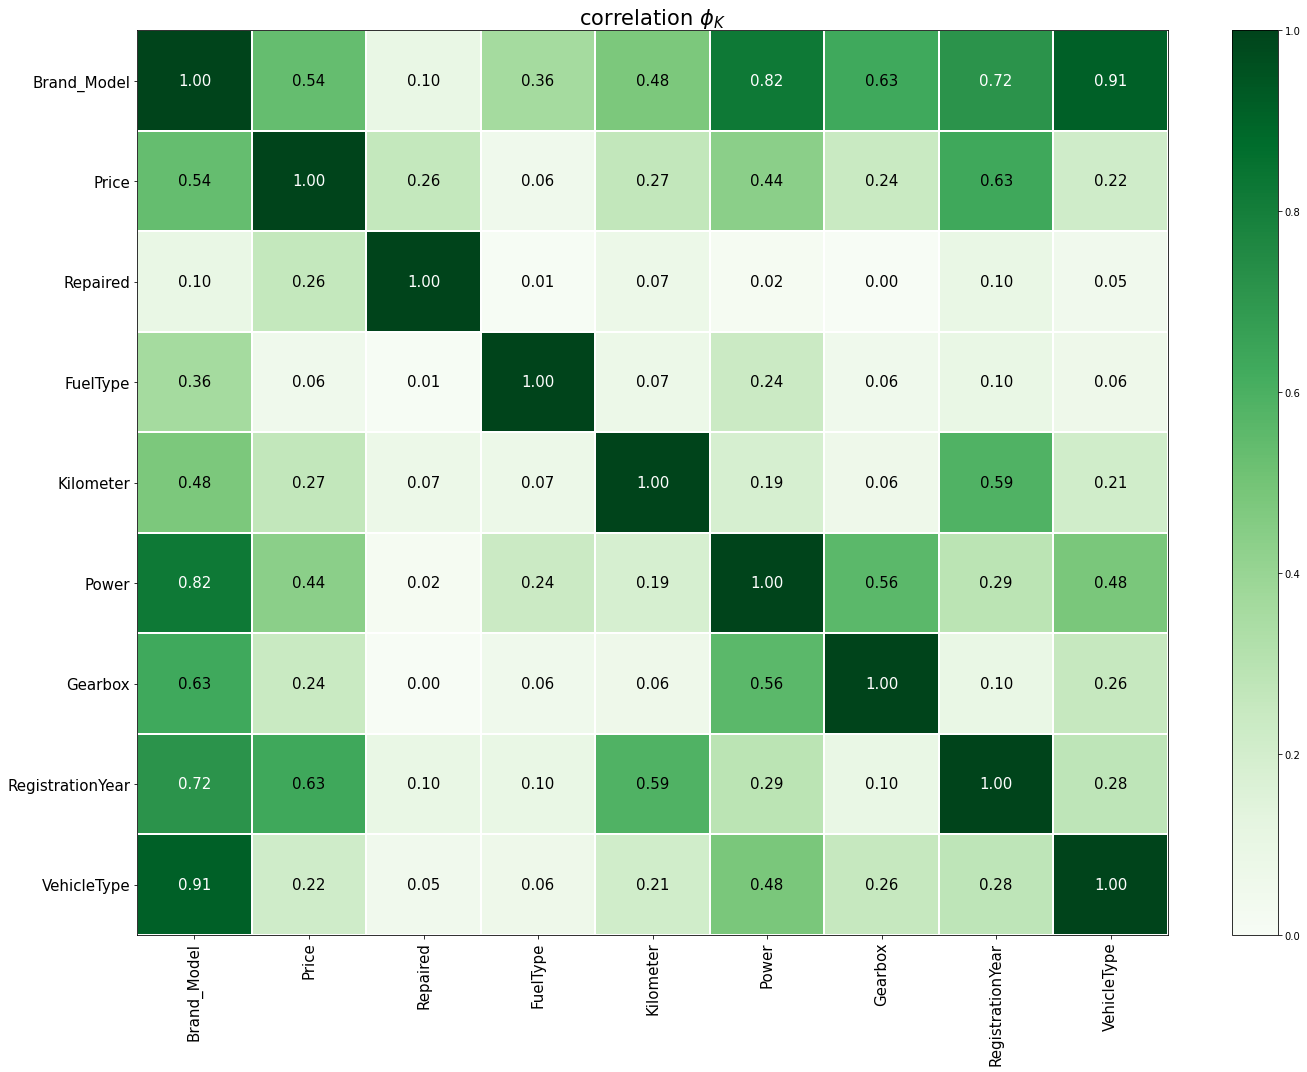

In [38]:
inter_cols = ['Price', 'Power', 'Kilometer']

matrix(data, inter_cols)

По матрице видимо, что сильнее всего на цену влияют: `Brand_Model`(0.54), `Power`(0.44), `ResistrationYear`(0.63)

### Промежуточный вывод

В пункте 1 проведена загрузка и подготовка данных: 

 - загружен датасет (354,369 строк)
 - удалены дубликаты (45,040) 
 - обработаны аномалии (Price 500–14,600, RegistrationYear 1970–2016, Power 0–400)
 - заполнены пропуски (VehicleType, Gearbox, Model, FuelType по моде Brand/Brand_Model, Repaired — 'no')
 - объединены Brand и Model в Brand_Model
 - проведен корреляционный анализ (сильнее всего на Price влияют RegistrationYear (0.63), Brand_Model (0.54), Power (0.44)).

<a id="section2"></a>
## Обучение моделей

Перед нами задача предсказания цены => задача регресии

Обучим 4 ML-модели: LinearRegressor DesicionTreeRegressor, CatBoostRegressor и LightGBMRegressor

### Разделение данных

In [39]:
X = data.drop(columns=['Price'])
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

### Определение признаков

In [40]:
cat_features_ohe = ['VehicleType', 'FuelType']

cat_features_ord = ['Gearbox', 'Repaired']

num_features = ['RegistrationYear', 'Power', 'Kilometer']

### Препроцессинг

In [41]:
ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipeline, cat_features_ohe),
    ('ord', ord_pipeline, cat_features_ord),
    ('num', num_pipeline, num_features)
])

### Модель 1: Linear Regressor

In [42]:
pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

rmse_scores = -cross_val_score(pipe_lr, X_train, y_train, 
                               scoring='neg_root_mean_squared_error', 
                               cv=5, n_jobs=-1)

start_time = time.time()
pipe_lr.fit(X_train, y_train)
train_time_lr = time.time() - start_time

start_time = time.time()
pipe_lr.predict(X_train)
pred_time_lr = time.time() - start_time

print(f'LinearRegression RMSE: {rmse_scores.mean():.2f}')
print(f'Время обучения (s): {train_time_lr:.2f}')
print(f'Время предсказаний (s): {pred_time_lr:.2f}')

LinearRegression RMSE: 2433.16
Время обучения (s): 0.68
Время предсказаний (s): 0.30


### Модель 2: Decision Tree Regressor

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

dtr_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

dtr_params = {
    'model__max_depth': [3, 5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

dtr_search = RandomizedSearchCV(dtr_pipe, dtr_params, cv=5, n_iter=10, 
                                scoring='neg_root_mean_squared_error', 
                                random_state=RANDOM_STATE, verbose=1)

dtr_search.fit(X_train, y_train)

start_time = time.time()
dtr_search.best_estimator_.fit(X_train, y_train)
train_time_dtr = time.time() - start_time

start_time = time.time()
dtr_search.best_estimator_.predict(X_train)
pred_time_dtr = time.time() - start_time

print(f'Лучшие параметры DTR: {dtr_search.best_params_}')
print(f'DTR RMSE: {-dtr_search.best_score_:.2f}')
print(f'Время обучения (s): {train_time_dtr:.2f}')
print(f'Время предсказаний (s): {pred_time_dtr:.2f}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры DTR: {'model__min_samples_split': 10, 'model__max_depth': 20}
DTR RMSE: 1709.22
Время обучения (s): 0.89
Время предсказаний (s): 0.31


### Модель 3: CatBoostRegressor 

In [44]:
cat_features = ['Brand_Model', 'VehicleType', 'FuelType', 'Gearbox', 'Repaired'] 

model_cat = CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)

param_grid_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

random_search_cat = RandomizedSearchCV(model_cat, param_grid_cat, 
                                       cv=5, n_iter=10, 
                                       scoring='neg_root_mean_squared_error', 
                                       random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

random_search_cat.fit(X_train, y_train, cat_features=cat_features)

start_time = time.time()
random_search_cat.best_estimator_.fit(X_train, y_train, cat_features=cat_features)
train_time_cat = time.time() - start_time

start_time = time.time()
random_search_cat.best_estimator_.predict(X_train)
pred_time_cat = time.time() - start_time

print(f'Лучшие параметры CatBoost: {random_search_cat.best_params_}')
print(f'CatBoost RMSE: {-random_search_cat.best_score_:.2f}')
print(f'Время обучения (s): {train_time_cat:.2f}')
print(f'Время предсказаний (s): {pred_time_cat:.2f}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры CatBoost: {'learning_rate': 0.1, 'iterations': 300, 'depth': 6}
CatBoost RMSE: 1441.91
Время обучения (s): 31.49
Время предсказаний (s): 0.45


### Модель 4: LightGBM

In [45]:
lgbm_pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LGBMRegressor(random_state=RANDOM_STATE))
])

lgbm_params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 10, -1],
    'model__learning_rate': [0.01, 0.05, 0.1]
}

lgbm_search = RandomizedSearchCV(lgbm_pipe, lgbm_params, cv=5, n_iter=10, 
                                 scoring='neg_root_mean_squared_error', 
                                 random_state=RANDOM_STATE, verbose=1)

lgbm_search.fit(X_train, y_train)

start_time = time.time()
lgbm_search.best_estimator_.fit(X_train, y_train)
train_time_lgbm = time.time() - start_time

start_time = time.time()
lgbm_search.best_estimator_.predict(X_train)
pred_time_lgbm = time.time() - start_time

print(f'Лучшие параметры LGBM: {lgbm_search.best_params_}')
print(f'LGBM RMSE: {-lgbm_search.best_score_:.2f}')
print(f'Время обучения (s): {train_time_lgbm:.2f}')
print(f'Время предсказаний (s): {pred_time_lgbm:.2f}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры LGBM: {'model__n_estimators': 200, 'model__max_depth': -1, 'model__learning_rate': 0.1}
LGBM RMSE: 1597.44
Время обучения (s): 5.99
Время предсказаний (s): 2.41


<a id="section3"></a>
## Анализ моделей

### Анализ

| Модель                  | RMSE на кросс-валидации | Время обучения (сек.) | Время предсказания (сек.) |
|-------------------------|--------------------------|------------------------|---------------------------|
| Linear Regression       | 2433.16                  | 0.68                   | 0.30                      |
| Decision Tree Regressor | 1709.22                  | 0.89                   | 0.31                      |
| CatBoost Regressor      | 1441.91                  | 31.49                  | 0.45                      |
| LightGBM Regressor      | 1597.44                  |  5.99                  | 2.41                      |


**Качество предсказания (RMSE)**
 - `CatBoost Regressor` показал лучшее качество предсказания (RMSE = 1441.91).

 - Далее идут `LightGBM` (RMSE = 1597.44) и `Decision Tree` (RMSE = 1709.22).

 - `Linear Regression` имеет худшее качество (RMSE = 2433.16).

**Время обучения**
 - Самое быстрое обучение у `Linear Regression` (0.69 сек) и `Decision Tree` (0.91 сек).

 - `LightGBM` — 5.80 сек, `CatBoost` — самое долгое (31.75 сек).

**Время предсказания**
 - Быстрее всех предсказывают `Decision Tree` (0.29 сек) и `Linear Regression` (0.33 сек).

 - `CatBoost` — 0.47 сек, `LightGBM` — самое медленное (2.42 сек).

**Итоговый выбор модели***

Если ориентироваться только на качество, то `CatBoost Regressor` лидирует.

<u>Однако при выборе по соотношению время/качество:</u>

 - `Decision Tree Regressor` показывает достаточно хорошее качество (RMSE = 1709.22) при очень низком времени обучения и предсказания.

 - `LightGBM Regressor` немного точнее, но значительно дольше работает, особенно при предсказании (2.42 сек).

***Вывод:***
`Decision Tree Regressor` — оптимальная модель по соотношению качество/время.
Он обеспечивает хорошее качество предсказаний при минимальных временных затратах, что делает его подходящим выбором для задач с ограниченными ресурсами или требующих быстрой обработки.

In [46]:
best_model = dtr_search.best_estimator_

### Получение предсказаний на лучшей модели

In [47]:
y_pred_dtr = best_model.predict(X_test)
rmse_dtr = mean_squared_error(y_test, y_pred_dtr, squared=False)

print("DTR RMSE на тестовой выборке:", rmse_dtr)

DTR RMSE на тестовой выборке: 1698.6350145412825


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<a id="section4"></a>
## Общий вывод

В рамках проекта разработана модель для предсказания рыночной стоимости автомобилей на основе исторических данных. Проведена тщательная предобработка данных:

 - удалены дубликаты 
 - обработаны аномалии 
 - заполнены пропуски по моде или логическим значениям
 - объединены признаки Brand и Model в Brand_Model. 
 - Корреляционный анализ выявил ключевые факторы, влияющие на цену: RegistrationYear (0.63), Brand_Model (0.54), Power (0.44).

Обучены четыре модели: `LinearRegression`, `DecisionTreeRegressor`, `CatBoostRegressor` и `LightGBMRegressor`. 

**По итогам анализа:**

 - `CatBoost Regressor` показал лучшее качество (RMSE = 1441.91), но работает заметно дольше.

 - `LightGBM Regressor` — близкий по качеству (RMSE = 1597.44), но требует больше времени на предсказание (2.42 сек.).

 - `Decision Tree Regressor` уступает в точности, но выигрывает в времени обучения и предсказания, при этом RMSE остаётся приемлемым (1709.22).

С учётом баланса между качеством и временем, `Decision Tree Regressor` признан оптимальной моделью:
он обеспечивает достойное качество при минимальных затратах времени — это важно для быстрой работы в реальном приложении и на ограниченных ресурсах.

На тестовой выборке `Decision Tree Regressor` показал RMSE = 1698.64, что подтверждает его устойчивость и способность обобщать.